In [1]:
import math, itertools, copy
import numpy as np
import matplotlib.pyplot as plt

from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.models import ClusterGraph, MarkovModel, BayesianModel
from pgmpy.inference.ExactInference import BeliefPropagation

from pgm_utils import *
from pgm_algorithms import MeanFieldInference, LoopyBeliefPropagation

%matplotlib inline

In [2]:
def experiment_1():
    # Set up factors
    np.random.seed(seed=1)
    intervals = [(1,10),(1,20),(5,10),(5,20)]

    factor_A = DiscreteFactor(variables=["A"], cardinality=[2],
                              values=np.random.uniform(intervals[0][0], intervals[0][1],size=(2)))
    factor_B = DiscreteFactor(variables=["B"], cardinality=[2],
                              values=np.random.uniform(intervals[1][0], intervals[1][1],size=(2)))
    factor_C = DiscreteFactor(variables=["C"], cardinality=[2],
                              values=np.random.uniform(intervals[2][0], intervals[2][1],size=(2)))
    factor_D = DiscreteFactor(variables=["D"], cardinality=[2],
                              values=np.random.uniform(intervals[3][0], intervals[3][1],size=(2)))
    factor_E = DiscreteFactor(variables=["E"], cardinality=[2],
                              values=np.random.uniform(intervals[0][0], intervals[0][1],size=(2)))

    factor_AB = DiscreteFactor(variables=["A", "B"], cardinality=[2,2],
                               values=np.random.uniform(intervals[0][0], intervals[0][1],size=(2,2)))
    factor_BCD = DiscreteFactor(variables=["B", "C", "D"], cardinality=[2,2,2],
                                values=np.random.uniform(intervals[1][0], intervals[1][1],size=(2,2,2)))
    factor_AD = DiscreteFactor(variables=["A", "D"], cardinality=[2,2],
                               values=np.random.uniform(intervals[2][0], intervals[2][1],size=(2,2)))
    factor_CE = DiscreteFactor(variables=["C", "E"], cardinality=[2,2],
                               values=np.random.uniform(intervals[3][0], intervals[3][1],size=(2,2)))

    my_factors = [factor_A, factor_B, factor_C, factor_D, factor_E,
                  factor_AB, factor_BCD, factor_AD, factor_CE]

    network = MarkovModel([("A","B"), ("B","C"),("B","D"), ("C","D"), ("A","D"),("C","E")])
    network.add_factors(*my_factors)
    print("Is model valid?", network.check_model())
    
    for f in my_factors:
        f.normalize()
    
    for f in my_factors:
        print(f)
    
    return my_factors, network

In [3]:
my_factors, network = experiment_1()

Is model valid? True
╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.3885 │
├─────┼──────────┤
│ A_1 │   0.6115 │
╘═════╧══════════╛
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.1294 │
├─────┼──────────┤
│ B_1 │   0.8706 │
╘═════╧══════════╛
╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.5122 │
├─────┼──────────┤
│ C_1 │   0.4878 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.4335 │
├─────┼──────────┤
│ D_1 │   0.5665 │
╘═════╧══════════╛
╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.4387 │
├─────┼──────────┤
│ E_1 │   0.5613 │
╘═════╧══════════╛
╒═════╤═════╤════════════╕
│ A   │ B   │   phi(A,B) │
╞═════╪═════╪════════════╡
│ A_0 │ B_0 │     0.2015 │
├─────┼─────┼────────────┤
│ A_0 │ B_1 │     0.3026 │
├─────┼─────┼────────────┤
│ A_1 │ B_0 │     0.1199 │
├─────┼─────┼────────────┤
│ A_1 │ B_1 │     0.3759 │
╘═════╧═════╧════════════╛
╒═════╤═════╤════

In [4]:
# Test MFA
mfa = MeanFieldInference(my_factors)
mfa_h = mfa.mean_field_approximation()
for _,q in mfa.Q.items():
    print(q.normalize(inplace=False))

╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.4225 │
├─────┼──────────┤
│ C_1 │   0.5775 │
╘═════╧══════════╛
╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.4309 │
├─────┼──────────┤
│ E_1 │   0.5691 │
╘═════╧══════════╛
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.2758 │
├─────┼──────────┤
│ B_1 │   0.7242 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.4496 │
├─────┼──────────┤
│ D_1 │   0.5504 │
╘═════╧══════════╛
╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.4237 │
├─────┼──────────┤
│ A_1 │   0.5763 │
╘═════╧══════════╛


Number of iterations: 38


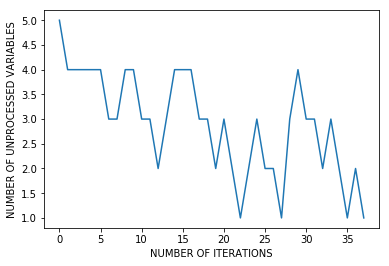

In [5]:
print("Number of iterations:", mfa_h["iterations"])
plt.plot(mfa_h["processed"])
plt.xlabel("NUMBER OF ITERATIONS")
plt.ylabel("NUMBER OF UNPROCESSED VARIABLES")
plt.show()

In [6]:
# Test LBP
lbp = LoopyBeliefPropagation(my_factors)
lbp_h = lbp.loopy_belief_propagation(lambd=0.5, num_iterations=300)

Loopy BP has converged.


In [7]:
for _,cb in lbp.cluster_beliefs.items():
    print(cb.normalize(inplace=False))

╒═════╤═════╤════════════╕
│ A   │ D   │   phi(A,D) │
╞═════╪═════╪════════════╡
│ A_0 │ D_0 │     0.0987 │
├─────┼─────┼────────────┤
│ A_0 │ D_1 │     0.2040 │
├─────┼─────┼────────────┤
│ A_1 │ D_0 │     0.2662 │
├─────┼─────┼────────────┤
│ A_1 │ D_1 │     0.4311 │
╘═════╧═════╧════════════╛
╒═════╤═════╤═════╤══════════════╕
│ B   │ C   │ D   │   phi(B,C,D) │
╞═════╪═════╪═════╪══════════════╡
│ B_0 │ C_0 │ D_0 │       0.0009 │
├─────┼─────┼─────┼──────────────┤
│ B_0 │ C_0 │ D_1 │       0.0110 │
├─────┼─────┼─────┼──────────────┤
│ B_0 │ C_1 │ D_0 │       0.0110 │
├─────┼─────┼─────┼──────────────┤
│ B_0 │ C_1 │ D_1 │       0.0204 │
├─────┼─────┼─────┼──────────────┤
│ B_1 │ C_0 │ D_0 │       0.0331 │
├─────┼─────┼─────┼──────────────┤
│ B_1 │ C_0 │ D_1 │       0.0610 │
├─────┼─────┼─────┼──────────────┤
│ B_1 │ C_1 │ D_0 │       0.3199 │
├─────┼─────┼─────┼──────────────┤
│ B_1 │ C_1 │ D_1 │       0.5427 │
╘═════╧═════╧═════╧══════════════╛
╒═════╤═════╤════════════╕
│ A   │ B  

In [8]:
for _,sb in lbp.sepset_beliefs.items():
    print(sb.normalize(inplace=False))

╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.3027 │
├─────┼──────────┤
│ A_1 │   0.6973 │
╘═════╧══════════╛
╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.1060 │
├─────┼──────────┤
│ C_1 │   0.8940 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.3649 │
├─────┼──────────┤
│ D_1 │   0.6351 │
╘═════╧══════════╛
╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.2686 │
├─────┼──────────┤
│ E_1 │   0.7314 │
╘═════╧══════════╛
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.0433 │
├─────┼──────────┤
│ B_1 │   0.9567 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.3649 │
├─────┼──────────┤
│ D_1 │   0.6351 │
╘═════╧══════════╛
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.0433 │
├─────┼──────────┤
│ B_1 │   0.9567 │
╘═════╧══════════╛
╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.

Number of iterations: 157


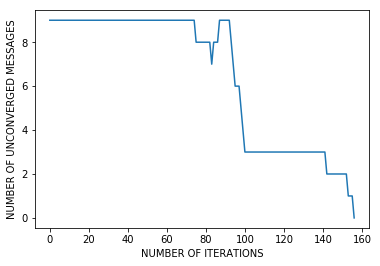

In [9]:
print("Number of iterations:", lbp_h["iterations"])
plt.plot(lbp_h["convergence"])
plt.xlabel("NUMBER OF ITERATIONS")
plt.ylabel("NUMBER OF UNCONVERGED MESSAGES")
plt.show()

In [10]:
# Exact inference
bp = BeliefPropagation(network)
bp.calibrate()
vars_to_query = set()
for f in my_factors:
    vars_query = f.scope()
    vars_to_query = vars_to_query.union(vars_query)
for v in vars_to_query:
    f = bp.query([v])
    print(f[v])

╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.1061 │
├─────┼──────────┤
│ C_1 │   0.8939 │
╘═════╧══════════╛
╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.2686 │
├─────┼──────────┤
│ E_1 │   0.7314 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.3650 │
├─────┼──────────┤
│ D_1 │   0.6350 │
╘═════╧══════════╛
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.0434 │
├─────┼──────────┤
│ B_1 │   0.9566 │
╘═════╧══════════╛
╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.3028 │
├─────┼──────────┤
│ A_1 │   0.6972 │
╘═════╧══════════╛


In [11]:
for _, val in bp.get_clique_beliefs().items():
    print(val.normalize(inplace=False))

╒═════╤═════╤═════╤══════════════╕
│ A   │ D   │ B   │   phi(A,D,B) │
╞═════╪═════╪═════╪══════════════╡
│ A_0 │ D_0 │ B_0 │       0.0050 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ D_0 │ B_1 │       0.0932 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ D_1 │ B_0 │       0.0155 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ D_1 │ B_1 │       0.1891 │
├─────┼─────┼─────┼──────────────┤
│ A_1 │ D_0 │ B_0 │       0.0066 │
├─────┼─────┼─────┼──────────────┤
│ A_1 │ D_0 │ B_1 │       0.2603 │
├─────┼─────┼─────┼──────────────┤
│ A_1 │ D_1 │ B_0 │       0.0163 │
├─────┼─────┼─────┼──────────────┤
│ A_1 │ D_1 │ B_1 │       0.4141 │
╘═════╧═════╧═════╧══════════════╛
╒═════╤═════╤═════╤══════════════╕
│ C   │ D   │ B   │   phi(C,D,B) │
╞═════╪═════╪═════╪══════════════╡
│ C_0 │ D_0 │ B_0 │       0.0008 │
├─────┼─────┼─────┼──────────────┤
│ C_0 │ D_0 │ B_1 │       0.0331 │
├─────┼─────┼─────┼──────────────┤
│ C_0 │ D_1 │ B_0 │       0.0112 │
├─────┼─────┼─────┼──────────────┤
│ C_0 │ D_1 │ B_1 │ 

In [12]:
for _, val in bp.get_sepset_beliefs().items():
    print(val.normalize(inplace=False))

╒═════╤═════╤════════════╕
│ D   │ B   │   phi(D,B) │
╞═════╪═════╪════════════╡
│ D_0 │ B_0 │     0.0116 │
├─────┼─────┼────────────┤
│ D_0 │ B_1 │     0.3534 │
├─────┼─────┼────────────┤
│ D_1 │ B_0 │     0.0318 │
├─────┼─────┼────────────┤
│ D_1 │ B_1 │     0.6032 │
╘═════╧═════╧════════════╛
╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.1061 │
├─────┼──────────┤
│ C_1 │   0.8939 │
╘═════╧══════════╛
